# Profiling compute/speed

I came across 3 major ways of profiling:

    1. deterministic: every function call is included in the profile
    
    2. statistical: the process is sampled every X seconds, only those samples are included in the profile
    
    3. line profiling: each line of code is timed seperately
    

## Option 1: deterministic profiling

CPython is the build in tool for this. 
This is nice for very small scripts, but it quickly becomes very hard to analyse. An example:

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.display import SVG
import pstats

In [3]:
from pathlib import Path
path = Path("../../../anomaly_detection/scripts/config/fast_end_to_end_experiment.json")
absolute_path_config = path.absolute()

In [4]:
!python -W ignore -m cProfile -o profile.prof ../../../anomaly_detection/scripts/fast_end_to_end_experiment.py --config {absolute_path_config} --skip-mlflow prepare-dataset

2024-04-04 18:32:30,327 [WARNING] anomaly_detection.pipeline.model.trend_converters.base pid=3740: Overwriting value for minimum_hours_per_window which was used to train the trend converter 336 -> 720
2024-04-04 18:32:30,608 [WARNING] anomaly_detection.pipeline.model.trend_converters.base pid=3740: Overwriting value for maximum_window_size which was used to train the trend converter 9000 -> 60000
2024-04-04 18:32:30,608 [WARNING] anomaly_detection.pipeline.model.trend_converters.base pid=3740: Overwriting value for minimum_window_size which was used to train the trend converter 180 -> 100
2024-04-04 18:32:31,141 [INFO] anomaly_detection.pipeline.commons pid=3740: Select failure mode(s): ['active_power']
2024-04-04 18:32:31,148 [INFO] anomaly_detection.pipeline.data.data_loader pid=3740: Loading labels from: s3://sl-saturncloud-workspace-research/anomaly_detection/label_periods/label_periods_20240328
2024-04-04 18:32:31,268 [INFO] anomaly_detection.pipeline.commons pid=3740: Select fail

In [5]:
p = pstats.Stats("profile.prof")
p.sort_stats("cumulative")
print(f"There are {len(p.stats)} function calls in the stats overview \n")
p.print_stats(10)

There are 21040 function calls in the stats overview 

Thu Apr  4 18:39:21 2024    profile.prof

         85654850 function calls (84188970 primitive calls) in 417.551 seconds

   Ordered by: cumulative time
   List reduced from 21040 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   4896/1    0.077    0.000  417.570  417.570 {built-in method builtins.exec}
        1    0.016    0.016  417.570  417.570 ../../../anomaly_detection/scripts/fast_end_to_end_experiment.py:1(<module>)
        1    0.002    0.002  409.724  409.724 ../../../anomaly_detection/scripts/fast_end_to_end_experiment.py:32(prepare_dataset)
        2    0.291    0.145  371.734  185.867 /opt/saturncloud/envs/saturn/lib/python3.8/site-packages/dask/local.py:346(get_async)
        1    0.000    0.000  368.501  368.501 /home/jovyan/git-repos/research/anomaly_detection/pipeline/data/dataset_generator.py:174(generate)
        1    0.001    0.001  368.425  368.425 /opt/sa

In [6]:
!snakeviz "profile.prof"

snakeviz web server started on 127.0.0.1:8080; enter Ctrl-C to exit
http://127.0.0.1:8080/snakeviz/%2Fhome%2Fjovyan%2Fgit-repos%2Fresearch%2Fpersonal_development%2Fefficient_python%2FH2_profiling%2Fprofile.prof
snakeviz: error: no web browser found: could not locate runnable browser

usage: snakeviz [-h] [-v] [-H ADDR] [-p PORT] [-b BROWSER_PATH] [-s] filename

Start SnakeViz to view a Python profile.

positional arguments:
  filename              Python profile to view

optional arguments:
  -h, --help            show this help message and exit
  -v, --version         show program's version number and exit
  -H ADDR, --hostname ADDR
                        hostname to bind to (default: 127.0.0.1)
  -p PORT, --port PORT  port to bind to; if this port is already in use a free
                        port will be selected automatically (default: 8080)
  -b BROWSER_PATH, --browser BROWSER_PATH
                        name of webbrowser to launch as described in the
                       

# Option 2: Statistical profiling

Statistical profiling increases intepretability as the profiler samples the process every X seconds. This means that short calls that do not influence the runtime significantly are left out of the chart.

Packages for this are for example Pyinstrument ot py-spy.
However, Pyinstrument can not handle multiple threads, or code build on top of C such as numpy. 
So lets look into py-spy. You can set the sampling rate in number of samples per second with the -r flag:

#### 10 samples per second

In [7]:
!py-spy record -r 10 -o profile10.svg -- python -W ignore ../../../anomaly_detection/scripts/fast_end_to_end_experiment.py --config {absolute_path_config} --skip-mlflow prepare-dataset

py-spy> Sampling process 10 times a second. Press Control-C to exit.

2024-04-04 18:39:29,127 [WARNING] anomaly_detection.pipeline.model.trend_converters.base pid=4864: Overwriting value for minimum_hours_per_window which was used to train the trend converter 336 -> 720
2024-04-04 18:39:29,503 [WARNING] anomaly_detection.pipeline.model.trend_converters.base pid=4864: Overwriting value for maximum_window_size which was used to train the trend converter 9000 -> 60000
2024-04-04 18:39:29,503 [WARNING] anomaly_detection.pipeline.model.trend_converters.base pid=4864: Overwriting value for minimum_window_size which was used to train the trend converter 180 -> 100
2024-04-04 18:39:30,116 [INFO] anomaly_detection.pipeline.commons pid=4864: Select failure mode(s): ['active_power']
2024-04-04 18:39:30,121 [INFO] anomaly_detection.pipeline.data.data_loader pid=4864: Loading labels from: s3://sl-saturncloud-workspace-research/anomaly_detection/label_periods/label_periods_20240328
2024-04-04 18:39:

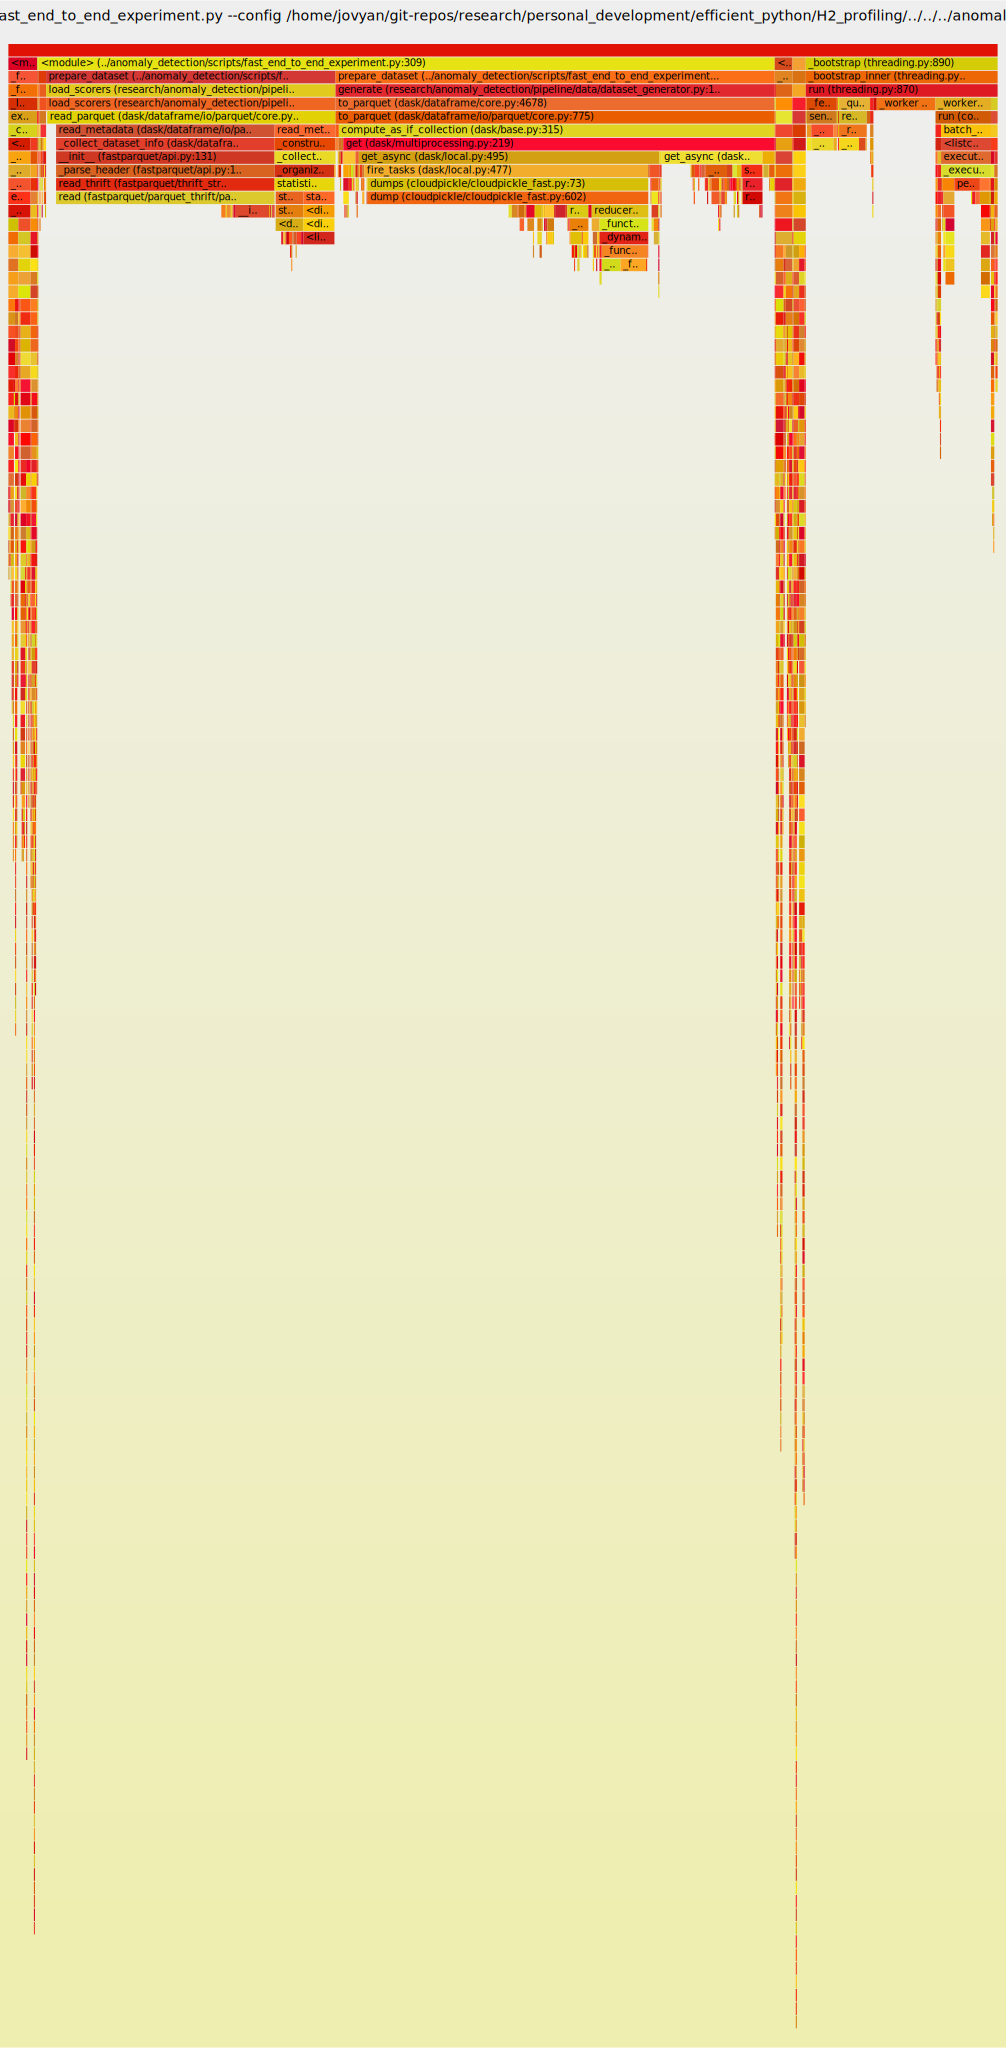

In [8]:
SVG("profile10.svg")

#### 1 sample per second

In [9]:
import warnings
warnings.filterwarnings('ignore')

In [10]:
!py-spy record -r 1 -o profile1.svg -- python -W ignore ../../anomaly_detection/scripts/fast_end_to_end_experiment.py --config {absolute_path_config} --skip-mlflow prepare-dataset

python: can't open file '../../anomaly_detection/scripts/fast_end_to_end_experiment.py': [Errno 2] No such file or directory
Error: Failed to get process executable name. Check that the process is running.
Reason: No such file or directory (os error 2)
Reason: No such file or directory (os error 2)


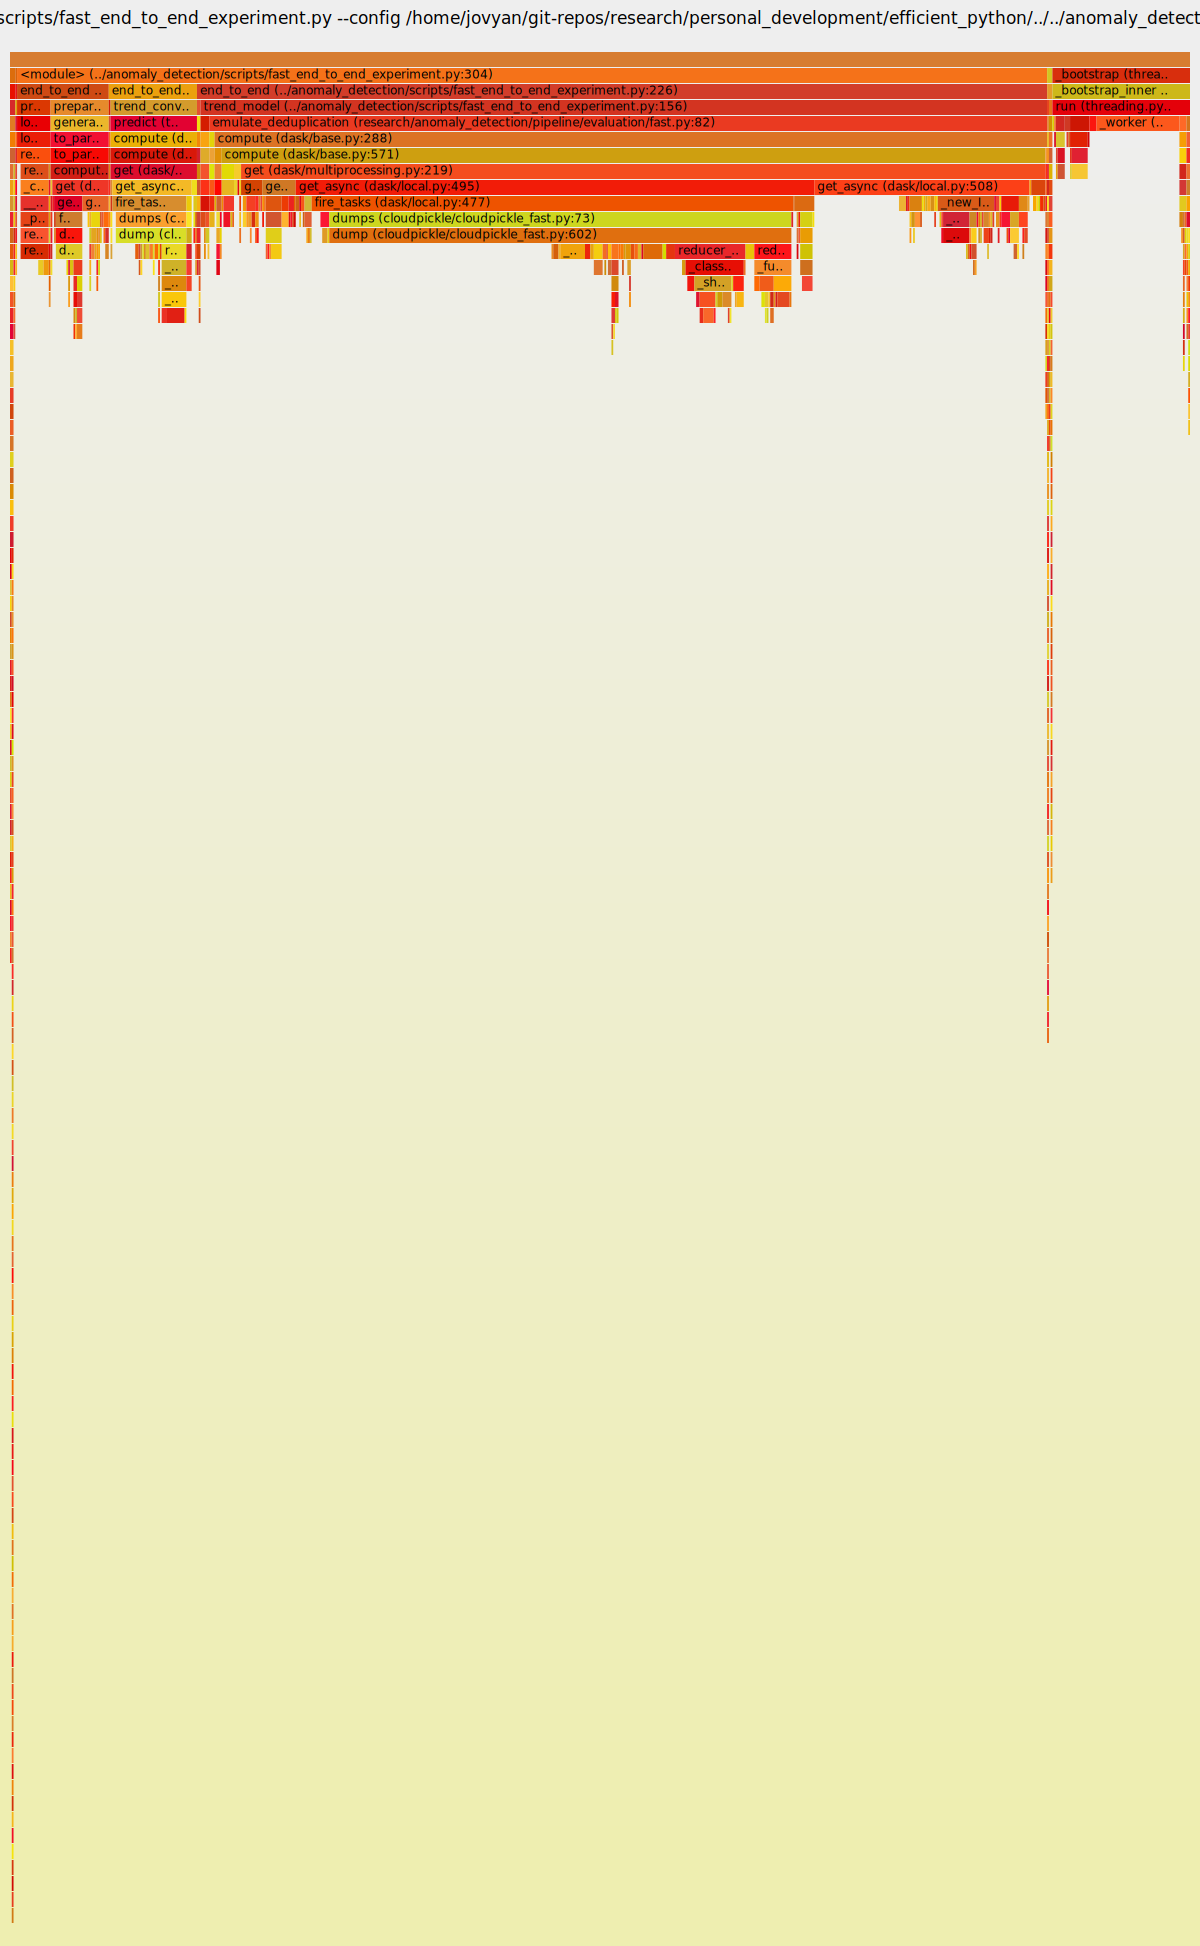

In [11]:
SVG("profile1.svg")

### Combine py-spy with this nice profiling viz tool: https://www.speedscope.app/

In [12]:
!py-spy record --format speedscope -r 10 -o profile.speedscope.json -- python -W ignore ../../../anomaly_detection/scripts/fast_end_to_end_experiment.py --config {absolute_path_config} --skip-mlflow end-to-end

py-spy> Sampling process 10 times a second. Press Control-C to exit.

2024-04-04 18:45:59,125 [WARNING] anomaly_detection.pipeline.model.trend_converters.base pid=5960: Overwriting value for minimum_hours_per_window which was used to train the trend converter 336 -> 720
2024-04-04 18:45:59,531 [WARNING] anomaly_detection.pipeline.model.trend_converters.base pid=5960: Overwriting value for maximum_window_size which was used to train the trend converter 9000 -> 60000
2024-04-04 18:45:59,531 [WARNING] anomaly_detection.pipeline.model.trend_converters.base pid=5960: Overwriting value for minimum_window_size which was used to train the trend converter 180 -> 100
2024-04-04 18:46:00,107 [INFO] anomaly_detection.pipeline.commons pid=5960: Select failure mode(s): ['active_power']
2024-04-04 18:46:00,112 [INFO] anomaly_detection.pipeline.data.data_loader pid=5960: Loading labels from: s3://sl-saturncloud-workspace-research/anomaly_detection/label_periods/label_periods_20240328
2024-04-04 18:46:

# Option 3: line profiler

My personal favourite is to profile the code line by line, using https://github.com/pyutils/line_profiler.

One downside is that you have to add the profiler decorator, and thus remove this when committing code.

Note that instead of using their buildin @profile decorator, a costum one is used here because that allows for profiling 
functions from other files then \_\_main\_\_.

In [13]:
from profiling_utils import profile
import inspect
from IPython.display import display, Markdown

source_code = inspect.getsource(profile)
display(Markdown(f"```python\n{source_code}\n```"))

```python
def profile(func):
    """
    Decorator that profiles the cimpute time of the decorated function.
    """
    from functools import wraps

    @wraps(func)
    def wrapper(*args, **kwargs):
        from line_profiler import LineProfiler

        prof = LineProfiler()
        try:
            return prof(func)(*args, **kwargs)
        finally:
            prof.print_stats()

    return wrapper

```

In [14]:
!python -W ignore  ../../../anomaly_detection/scripts/fast_end_to_end_experiment.py --config {absolute_path_config} --skip-mlflow end-to-end

2024-04-04 18:52:16,024 [WARNING] anomaly_detection.pipeline.model.trend_converters.base pid=7159: Overwriting value for minimum_hours_per_window which was used to train the trend converter 336 -> 720
2024-04-04 18:52:16,281 [WARNING] anomaly_detection.pipeline.model.trend_converters.base pid=7159: Overwriting value for maximum_window_size which was used to train the trend converter 9000 -> 60000
2024-04-04 18:52:16,281 [WARNING] anomaly_detection.pipeline.model.trend_converters.base pid=7159: Overwriting value for minimum_window_size which was used to train the trend converter 180 -> 100
2024-04-04 18:52:16,878 [INFO] anomaly_detection.pipeline.commons pid=7159: Select failure mode(s): ['active_power']
2024-04-04 18:52:16,882 [INFO] anomaly_detection.pipeline.data.data_loader pid=7159: Loading labels from: s3://sl-saturncloud-workspace-research/anomaly_detection/label_periods/label_periods_20240328
2024-04-04 18:52:16,982 [INFO] anomaly_detection.pipeline.commons pid=7159: Select fail